# Домашнее задание
Реализация алгоритма DQN. В этой работе реализован как базовый вариант алгоритма DQN, так и с мягким обновлением целевой сети. Агент обучен в среде `LunarLander-v3`  


### Подгтовка

In [1]:
# !pip install "gymnasium[box2d]"  #  если зависимости установлены из requirements.txt
# !pip install "gymnasium[other]"  #  - должно работать без этого

In [2]:
import os
import sys
import math
import random
from time import time

import gymnasium
sys.modules["gym"] = gymnasium

import gymnasium as gym
from gym.wrappers import RecordVideo

from base64 import b64encode
from IPython.display import HTML
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("CUDA доступна:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

CUDA доступна: True


In [3]:
os.makedirs("./video", exist_ok=True)

def render_mp4(videopath: str) -> str:

    """
    Функция для рендеринга видео в формате mp4.
    Args:
    videopath - Путь к файлу с видео.
    """
    
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=600 controls><source src="data:video/mp4; base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
BATCH_SIZE = 128   # количество эпизодов, отобранных из буфера воспроизведения
GAMMA = 0.995       # коэффициент дисконтирования
EPS_START = 0.9    # начальное значение эпсилон
EPS_END = 0.05     # конечное значение эпсилон
EPS_DECAY = 10000   # скорость экспоненциального спада эпсилон, чем больше - тем медленнее падение
TAU = 0.005        # скорость обновления целевой сети
LR = 5e-5          # скорость обучения оптимизатора `AdamW`
FULL_MEMORY_LENGTH = 1000000   # длинна памяти
TARGET_UPDATE_FREQ = 10 # жёсткое обновление целевой сети (если нет мягкого обновления)
MAX_EPISODE_STEPS = 1500 # максимальное количество итераций в эпизоде
EPISODES_CNT = 2000 # количество эпизодов

env = gym.make(
    "LunarLander-v3",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 5.0,        # *
    turbulence_power = 1.1,  # *
    max_episode_steps=MAX_EPISODE_STEPS,
    render_mode="rgb_array"
)

# параметр episode_trigger=lambda e: True # для выгрузки КАЖДОГО ВИДЕО
# env = RecordVideo(env, video_folder="video", name_prefix=f"LunarLander", episode_trigger=lambda ep: ep % 200 == 0)
# ( !!! рендеринг видео будет включен только для второй "улучшенной" нейросети )

# число действий
n_actions = env.action_space.n

# число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

$*$ Для повышения сложности задачи в настройках среды включены ветер и турбулентность. 

#### Служебные функции для отрисовки прогресса обучения

In [5]:
def MA_rectifier(data, window_size):
    """
    Применяет метод скользящего среднего, добавляет нули в начало списка
    """
    
    data_lenght = len(np.array(data))
    window_data = np.convolve(np.array(data), np.ones(window_size) / window_size, mode='valid').tolist()
    full_data = [0]*len(range(data_lenght - len(window_data)))
    full_data.extend(window_data)
    return [int(i) for i in full_data]

def drow_graph(data1, data2, window_size):
    """
    Сглаженный график зависимости награды от количества итераций
    """

    fig, ax1 = plt.subplots(figsize=(13, 5))

    l1, = ax1.plot(range(1, len(data1) + 1),
                    MA_rectifier(data1, window_size),
                    color='steelblue', label='Итераций в эпизоде')

    ax2 = ax1.twinx()
    l2, = ax2.plot(range(1, len(data2) + 1),
                    MA_rectifier(data2, window_size),
                    color='orange', label='Награда')

    # Создаем единую легенду
    ax1.legend([l1, l2], ['Итераций в эпизоде', 'Награда'], loc='center right')

    # Опционально можно добавить подписи осей
    ax1.set_xlabel('Эпизоды')
    ax1.set_ylabel('Кол-во итераций')
    ax2.set_ylabel('Награда')

    plt.grid(False)
    plt.show()
    plt.close()


#### Функция Replay bufer'а

In [6]:

class ReplayMemory(object):
    """
    Класс для хранения и выборки данных из буфера
    """

    def __init__(self, capacity):      
        # deque - инициализация двусторонней очереди
        # capacity - макс. количество элементов, которые могут быть сохранены в буфер
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # добавление элементов в буфер
        self.memory.append(transition(*args))

    def sample(self, batch_size):
        # выбор элементов из буфера
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Сеть DQN

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        # n_observations: количество наблюдений
        # n_actions: количество действий

        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x) # возвращает тензор tensor([[left0exp,right0exp]...]) Q-значений для каждого действия

### Функция выбора действия

In [8]:
def select_action(state, policy_net):
    global steps_done  # глобальный шаги для убывания epsilon
    #  случайное определение какой шаг делать - жадный или случайный
    sample = random.random()
    
    # установка порога принятия решения - уровня epsilon
    # (функция экспоненциального затухания случайности жадной стратегии)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    # увеличиваем счетчик шагов
    steps_done += 1
    
    # если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места, 
            # где был найден максимальный элемент, 
            # поэтому выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Иначt выбираем случайное дайствие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

#### Функция оптимизации

In [9]:
def optimize_model(batch_size, optimizer, memory, target_net, policy_net, with_clip=False, gradient_clip_size=100):
    """
    Оптимизирует модель на основе памяти переходов.

    Аргументы:
        batch_size (int): Размер батча.
        optimizer (torch.optim.Optimizer): Оимизатор для обновления параметров модели
        memory (ReplayMemory): Replay memory
        target_net (nn.Module): Целевая сеть
        policy_net (nn.Module): Сеть политик
        with_clip (bool, optional): Следует ли обрезать градиенты (по умолчанию False)
    """
    
    # Если в памяти недостаточно переходов для формирования батча, выходим из функции.
    if len(memory) < batch_size:
        return
    
    # Получить случайный батч ииз памяти
    transitions = memory.sample(batch_size)
    # Преобразуем список переходов в именованный кортеж, где каждый элемент (state, action, next_state, reward) — кортеж.
    batch = transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)
    # - для каждого элемента батча проверяем, что next_state не None.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    # Объединяем все ненулевые (нефинальные) следующие состояния в один тензор.
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Объединяем батчи для текущих состояний, действий и наград:
    # torch.cat объединяет список тензоров в один тензор по первому измерению.
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward).float()

    # Прогоняем батч состояний через policy_net и выбираем Q-значения для совершенных действий < Q(s_t, a) >.
    # .gather(1, action_batch) выбирает Q-значение по индексу действия для каждого состояния.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
    # либо 0, если состояние было финальным.

    # Инициализируем тензор для хранения Q-значений для следующих состояний с нулями.
    next_state_values = torch.zeros(batch_size, device=device)

    # Без вычисления градиентов:
    with torch.no_grad():
        # Для всех нефинальных состояний вычисляем максимальное Q-значение, используя target_net.
        # next_state_values[non_final_mask] обновляем только там, где next_state существует.
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Вычисляем ожидаемые Q-значения по формуле:
    # expected_Q = reward + GAMMA * max_a'(Q(next_state, a'))
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Выбираем функцию потерь: SmoothL1Loss (Huber loss) при обрезке градиентов, иначе стандартная MSELoss.
    if with_clip:
        criterion = nn.SmoothL1Loss()
    else:
        criterion = nn.MSELoss()    

    # Вычисляем лосс как разницу между Q-значениями, предсказанными сетью, и ожидаемыми Q-значениями.
    # expected_state_action_values.unsqueeze(1) добавляет дополнительное измерение для согласования форм.
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()  # Обнуляем накопленные градиенты
    loss.backward()        # Выполняем обратное распространение ошибки для вычисления градиентов

    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента (если включено)
    if with_clip:
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), gradient_clip_size)
    
     # Шаг оптимизации (обновляем параметры policy_net)
    optimizer.step()

#### Обучение агента #1
Примечание: *В формулировке задания сказано, что необходимо обучить агента с мягким обновлением целевой сети, однако для сравнения и собственного понимания различий я сначала обучаю агента с регулярным обновлением целевых весов и базовым оптимизатором Adam*

100%|██████████| 2000/2000 [1:39:28<00:00,  2.98s/it]  


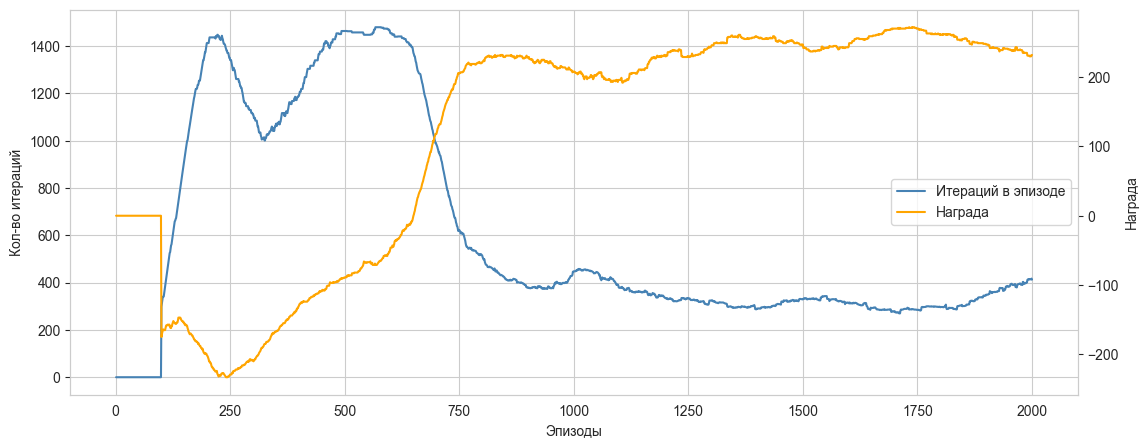

In [10]:
# Инициализируем сети: сеть политик (policy_net_basic) и целевую сеть (target_net_basic)
# Целевая сеть используется только для получения стабильных целевых значений
policy_net_basic = DQN(n_observations, n_actions).to(device)
target_net_basic = DQN(n_observations, n_actions).to(device)
target_net_basic.eval()  # Переводим целевую сеть в режим оценки (inference), чтобы отключить dropout/batchnorm

# Копируем параметры из сети политик в целевую сеть,
# чтобы начальное состояние обеих сетей было одинаковым
target_net_basic.load_state_dict(policy_net_basic.state_dict())

# Инициализируем оптимизатор для сети политик.
# Здесь используется Adam, который обновляет параметры с использованием градиентного спуска
optimizerAdam = optim.Adam(policy_net_basic.parameters(), lr=LR)

# Инициализируем Replay Memory для хранения переходов (состояние, действие, следующее состояние, награда)
memory_basic = ReplayMemory(FULL_MEMORY_LENGTH)

# Глобальная переменная для отслеживания общего количества шагов (используется для расчёта epsilon)
steps_done = 0

# Списки для хранения статистики: продолжительности эпизодов и суммарных наград за эпизод
episode_durations_basic = []
rewards_basic = []

# Запускаем цикл по эпизодам обучения
for i_episode in tqdm(range(EPISODES_CNT)):
    # Для каждого эпизода инициализируем начальное состояние окружения
    state, info = env.reset()
    # Преобразуем состояние в тензор типа float32 и добавляем измерение батча
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Инициализируем переменную для накопления награды за текущий эпизод
    episode_reward = 0.0
    
    # Цикл по шагам в эпизоде (максимальное количество шагов задается константой MAX_EPISODE_STEPS)
    for t in range(MAX_EPISODE_STEPS):
        # Выбираем действие по текущему состоянию,
        # используя функцию select_action, которая опирается на сеть политик
        action = select_action(state, policy_net=policy_net_basic)
        
        # Выполняем выбранное действие в окружении
        # Получаем новое наблюдение, награду и флаги завершения эпизода (terminated, truncated)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # Преобразуем награду в тензор типа float32 для согласования с остальными данными
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        
        # Объединяем флаги завершения: эпизод считается завершённым, если либо terminated, либо truncated равны True
        done = terminated or truncated
        
        # Если эпизод не завершился, преобразуем наблюдение в тензор состояния,
        # иначе задаём next_state как None, чтобы указать, что состояние финальное
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Сохраняем переход (state, action, next_state, reward) в буфер памяти
        memory_basic.push(state, action, next_state, reward)

        # Переходим к следующему состоянию для следующего шага
        state = next_state

        # Запускаем функцию оптимизации модели на случайном батче из памяти
        optimize_model(batch_size=128,
                       optimizer=optimizerAdam,
                       with_clip=False,
                       memory=memory_basic,
                       target_net=target_net_basic,
                       policy_net=policy_net_basic)

        # Накопление суммарной награды за эпизод.
        # Для этого добавляем числовое значение награды к переменной episode_reward
        episode_reward += reward.item()
        
        # Если получен сигнал завершения эпизода (done), выходим из цикла шагов
        if done:
            # Сохраняем суммарную награду за эпизод для дальнейшего анализа
            rewards_basic.append(float(episode_reward))
            # Сохраняем количество шагов, пройденных в этом эпизоде
            episode_durations_basic.append(t + 1)
            break

    # Жёсткое обновление целевой сети каждые TARGET_UPDATE_FREQ эпизодов:
    # параметры целевой сети полностью заменяются параметрами сети политик
    if i_episode % TARGET_UPDATE_FREQ == 0:
        target_net_basic.load_state_dict(policy_net_basic.state_dict())


drow_graph(episode_durations_basic, rewards_basic, 100)

#### Обучение агента #2
Здесь уже применяется обучение агента согласно поставленной задаче.

100%|██████████| 2000/2000 [3:11:09<00:00,  5.73s/it]  


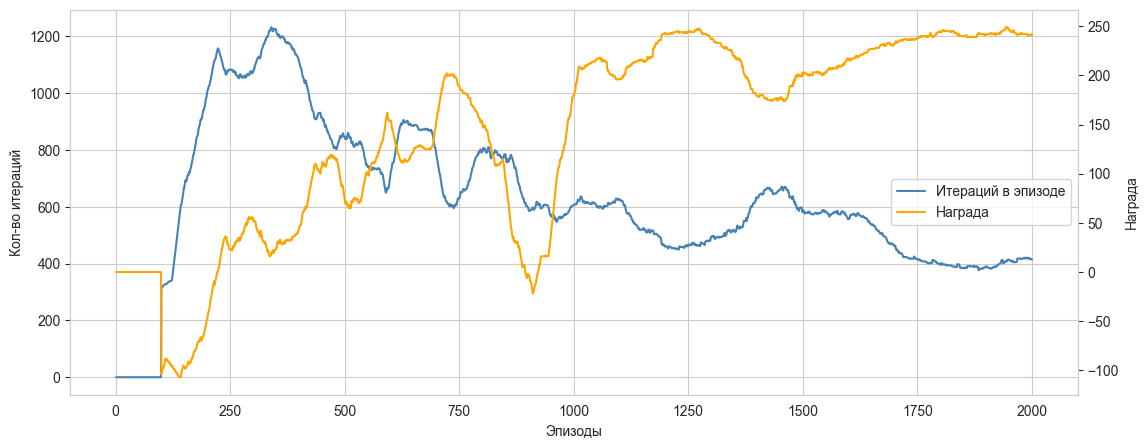

In [11]:
# включаем запись видео только для улучшенного DQN
env = RecordVideo(env, video_folder="video", name_prefix=f"LunarLander", episode_trigger=lambda ep: True)


# Инициализируем сети: сеть политик (policy_net_smoothed) и целевую сеть (target_net_smoothed)
# (как и в предыдущем примере, целевая сеть изначально получает те же параметры, что и сеть политик)
policy_net_smoothed = DQN(n_observations, n_actions).to(device)
target_net_smoothed = DQN(n_observations, n_actions).to(device)
target_net_smoothed.load_state_dict(policy_net_smoothed.state_dict())

# Инициализируем оптимизатор AdamW с использованием AMSGrad.
# AdamW отличается от стандартного Adam весовой декомпозицией регуляризации, что может улучшить сходимость.
optimizerAdamW = optim.AdamW(policy_net_smoothed.parameters(), lr=LR, amsgrad=True)

# Инициализируем Replay Memory для хранения переходов
memory_smoothed = ReplayMemory(FULL_MEMORY_LENGTH)

# Сброс счетчика шагов
steps_done = 0

# Списки для хранения статистики: продолжительности эпизодов и суммарных наград
episode_durations_smoothed = []
rewards_smoothed = []

# Цикл по эпизодам обучения
for i_episode in tqdm(range(EPISODES_CNT)):
    # Для каждого эпизода инициализируем начальное состояние окружения
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Инициализируем переменную для накопления награды за эпизод
    episode_reward = 0.0
    
    # Цикл по шагам в эпизоде (максимальное число шагов определяется MAX_EPISODE_STEPS)
    for t in range(MAX_EPISODE_STEPS):
        # Выбираем действие по текущему состоянию с помощью функции select_action,
        # используя сеть политик (policy_net_smoothed)
        action = select_action(state, policy_net=policy_net_smoothed)
        
        # Выполняем действие в окружении, получаем новое наблюдение, награду и флаги завершения эпизода
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # Преобразуем награду в тензор.
        # Обратите внимание: здесь не указан dtype, поэтому по умолчанию может получиться torch.float32
        # Если возникает несоответствие типов, можно явно указать: dtype=torch.float32
        reward = torch.tensor([reward], device=device)
        
        # Объединяем флаги завершения: эпизод считается завершённым, если либо terminated, либо truncated равны True
        done = terminated or truncated
        
        # Если эпизод завершился, next_state устанавливается в None (финальное состояние)
        if done:
            next_state = None
        else:
            # Если эпизод продолжается, преобразуем наблюдение в тензор состояния
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Сохраняем переход (state, action, next_state, reward) в буфер памяти
        memory_smoothed.push(state, action, next_state, reward)

        # Переходим к следующему состоянию для следующего шага
        state = next_state

        # Запускаем оптимизацию модели на случайном батче из памяти
        optimize_model(batch_size=128,
                       optimizer=optimizerAdamW,
                       with_clip=True,  # Здесь включена обрезка градиентов (clip), чтобы избежать взрыва градиентов
                       memory=memory_smoothed,
                       target_net=target_net_smoothed,
                       policy_net=policy_net_smoothed,
                       gradient_clip_size=80)

        # Мягкое обновление целевой сети:
        # Вместо жёсткого обновления (полного копирования весов), здесь веса целевой сети обновляются по формуле:
        # θ_target = TAU * θ_policy + (1 - TAU) * θ_target
        target_net_state_dict = target_net_smoothed.state_dict()
        policy_net_state_dict = policy_net_smoothed.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net_smoothed.load_state_dict(target_net_state_dict)

        # Накопление суммарной награды за эпизод.
        # Приводим награду к числовому значению и прибавляем к переменной episode_reward.
        episode_reward += reward.item()
               
        # Если эпизод завершился, сохраняем статистику и выходим из цикла шагов
        if done:
            rewards_smoothed.append(float(episode_reward))
            episode_durations_smoothed.append(t + 1)
            break
        

drow_graph(episode_durations_smoothed, rewards_smoothed, 100)

Посмотрим действия агента в последнем эпизоде:

In [12]:
HTML(
    render_mp4(f"video/LunarLander-episode-{max([int(i.split('.')[0].split('-')[-1]) for i in os.listdir('video')])}.mp4")
    )

### Заключение
В результате настройки видим, что более сложный алгоритм (с мягким обновлением целевой сети и оптимизатором AdamW) показывает менее стабильное обучение, однако итоговая средняя награда выше.   
Кроме того, включенные в настройках среды ветер и турбулентность, вероятно, также вносят коррективы в обучение, так как при первичной настройке алгоритмов без ветра и турбулентности, "продвинутый" алгоритм возвращал более стабильную кривую обучения.